## Startup.ML Challenge Problem
**by David Weisberger: david.weisberger@gmail.com**

### Language Detection
European Parliament Proceedings Parallel Corpus is a text dataset used for evaluating language detection engines. The 1.5GB corpus includes 21 languages spoken in EU.  

Create a machine learning model trained on this dataset to predict the following test set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
import glob
import os
from bs4 import BeautifulSoup
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn import pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.externals import joblib

**Note: After some experimentation, it seems possible to create a highly accurate model with only a very small subset of the available 1.5 GB of data. While ~200 MB are available per languages, I've chosen to train on only ~200 KB per language**

In [2]:
# choose files that are large enough to contain actual paragraphs
# for a varied corpus, write several smaller files per language to a single larger language file

#arbitrary bounds for files and overall model data per language
min_filesize = 10**3
max_filesize = 10**4  
max_size = 2*10**5
for lang in os.listdir('/Users/david/Downloads/txt/')[1:]:
    rows = []
    sizes = []
    tot_size = 0
    for file in glob.glob('/Users/david/Downloads/txt/{}/*.txt'.format(lang)):
        if os.stat(file).st_size > min_filesize and os.stat(file).st_size < max_filesize:
            sizes.append((file, os.stat(file).st_size))
    large_files = [i[0] for i in sorted(sizes, key = lambda x: x[1], reverse=True)]
    for file in large_files:
         if tot_size < max_size:
            with open(file, 'r+', errors = 'ignore') as f:
                read_data = f.read()
            soup_text = BeautifulSoup(read_data, 'lxml').text
            no_parens = re.sub(r'\([^)]*\)', '', soup_text) # get rid of text in parentheses (often another language)
            no_nums = re.sub(r'\d+', '', no_parens)
            rows.append(no_nums)
            tot_size += os.stat(file).st_size
    outfile = '/Users/david/Downloads/small_ML_langs/{}_data.txt'.format(lang)
    with open(outfile, 'w+') as fd:
        fd.write('\n'.join(rows))

In [3]:
# load X (sentences) and y (target language) into arrays
X = []
y = []
for file in glob.glob('/Users/david/Downloads/small_ML_langs/*.txt'):
    target_language = re.search(r'(\w+)_data', file).groups()[0]
    with open(file, 'r+') as f:
        read_data = f.read()
        split_data = re.split('[\n.;?]', read_data) # split on newlines and .;?
        split_data = [i for i in split_data if i] # remove empty strings
    X.extend(split_data)
    y.extend([target_language for line in split_data])
print('Total "sentences" in the training data: ', len(X))
print("\nSentences per language: ")
for k,v in Counter(y).items():
    print(k,v)

Total "sentences" in the training data:  28854

Sentences per language: 
nl 1330
bg 874
en 1428
cs 1408
fr 1314
lv 1564
da 1693
lt 1837
it 1279
sk 1411
de 1379
hu 1358
pl 1337
ro 1292
pt 1341
sl 1585
es 1221
et 1609
sv 1432
fi 1395
el 767


In [4]:
words = []
for i in X:
    words.extend(i.split())
num_letters = sum([len(word) for word in words])

print('Total "words" in corpus: ', len(words))
print('Total characters in corpus: ', num_letters)

Total "words" in corpus:  531721
Total characters in corpus:  3126478


In [5]:
# prepare training and test data from X,y with 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=1)

In [6]:
# train tfidf vectorizer on character ngrams, 1 to max_n characters long (ignoring whitespace)
max_n = 4

vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(1,max_n))
classifier = linear_model.LogisticRegression()
pipe = pipeline.Pipeline([('vectorizer', vectorizer), ('clf', classifier)])
pipe.fit(X_train, y_train);

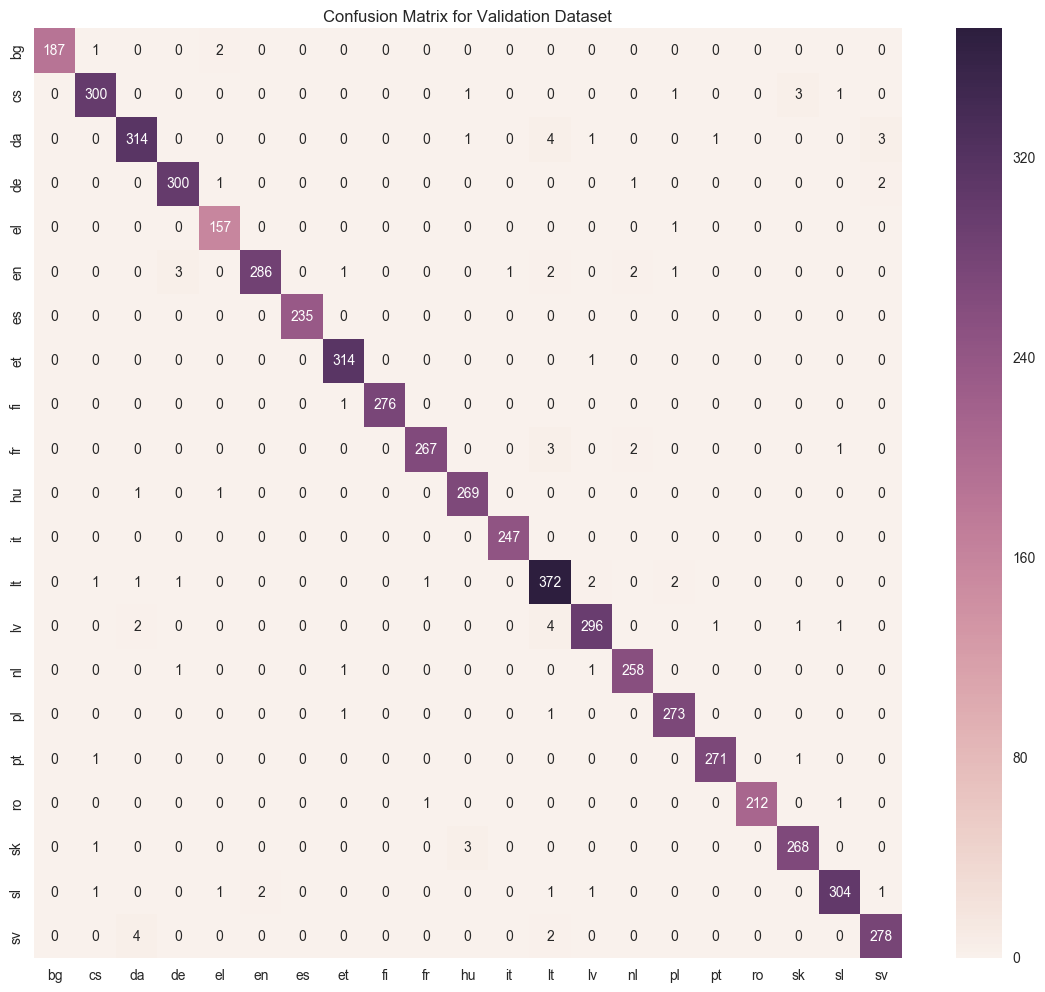

Test dataset classification metrics:

             precision    recall  f1-score   support

         bg       1.00      0.98      0.99       190
         cs       0.98      0.98      0.98       306
         da       0.98      0.97      0.97       324
         de       0.98      0.99      0.99       304
         el       0.97      0.99      0.98       158
         en       0.99      0.97      0.98       296
         es       1.00      1.00      1.00       235
         et       0.99      1.00      0.99       315
         fi       1.00      1.00      1.00       277
         fr       0.99      0.98      0.99       273
         hu       0.98      0.99      0.99       271
         it       1.00      1.00      1.00       247
         lt       0.96      0.98      0.97       380
         lv       0.98      0.97      0.98       305
         nl       0.98      0.99      0.98       261
         pl       0.98      0.99      0.99       275
         pt       0.99      0.99      0.99       273
       

In [7]:
# Confusion matrix and metrics for training/validation datasets
y_predicted = pipe.predict(X_val)
cm = metrics.confusion_matrix(y_val, y_predicted)

plt.figure(figsize=(14,12))
plt.title('Confusion Matrix for Validation Dataset')
label_names = list(np.unique(y))
sns.heatmap(cm, annot=True, xticklabels = label_names, yticklabels = label_names, fmt='d')
plt.show();

print("Test dataset classification metrics:\n")
print(metrics.classification_report(y_val, y_predicted))

In [8]:
# display most common misclassification by language (or perfect classification if none)
languages = ['Bulgarian', 'Czech', 'Danish', 'German', 'Greek', 'English', 
             'Spanish', 'Estonian', 'Finnish', 'French', 'Hungarian', 'Italian', 'Lithuanian',
            'Latvian', 'Dutch', 'Polish', 'Portuguese', 'Romanian', 'Slovakian', 'Slovenian', 'Swedish']

# for bold display, include markdown printing function
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

def second_most(cm):
    '''given confusion matrix, prints most common misclassification by language'''
    for idx, row in enumerate(cm):
        row_total = sum(row)
        if max(row) == row_total:
            printmd('*All **{}** correctly classified* \n'.format(languages[idx]))
        else:
            second_max = sorted(row, reverse=True)[1]
            second_index = list(row).index(second_max)
            second_lang = languages[second_index]
            printmd('*\t **{}** most commonly misclassified as **{}**: {} of {} \n'.format(languages[idx], second_lang, second_max, row_total))

second_most(cm)

*	 **Bulgarian** most commonly misclassified as **Greek**: 2 of 190 


*	 **Czech** most commonly misclassified as **Slovakian**: 3 of 306 


*	 **Danish** most commonly misclassified as **Lithuanian**: 4 of 324 


*	 **German** most commonly misclassified as **Swedish**: 2 of 304 


*	 **Greek** most commonly misclassified as **Polish**: 1 of 158 


*	 **English** most commonly misclassified as **German**: 3 of 296 


*All **Spanish** correctly classified* 


*	 **Estonian** most commonly misclassified as **Latvian**: 1 of 315 


*	 **Finnish** most commonly misclassified as **Estonian**: 1 of 277 


*	 **French** most commonly misclassified as **Lithuanian**: 3 of 273 


*	 **Hungarian** most commonly misclassified as **Danish**: 1 of 271 


*All **Italian** correctly classified* 


*	 **Lithuanian** most commonly misclassified as **Latvian**: 2 of 380 


*	 **Latvian** most commonly misclassified as **Lithuanian**: 4 of 305 


*	 **Dutch** most commonly misclassified as **German**: 1 of 261 


*	 **Polish** most commonly misclassified as **Estonian**: 1 of 275 


*	 **Portuguese** most commonly misclassified as **Czech**: 1 of 273 


*	 **Romanian** most commonly misclassified as **French**: 1 of 214 


*	 **Slovakian** most commonly misclassified as **Hungarian**: 3 of 272 


*	 **Slovenian** most commonly misclassified as **English**: 2 of 311 


*	 **Swedish** most commonly misclassified as **Danish**: 4 of 284 


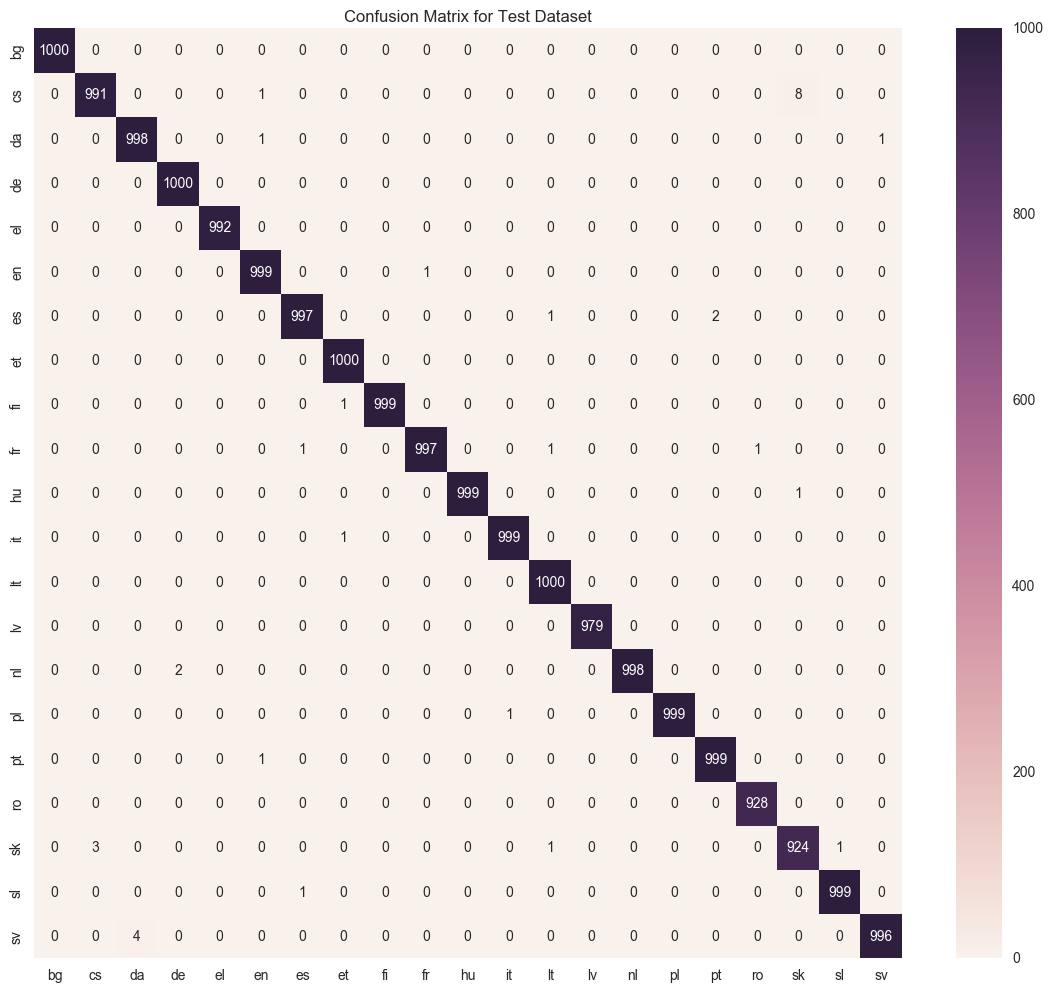

Test dataset classification metrics:

             precision    recall  f1-score   support

         bg       1.00      1.00      1.00      1000
         cs       1.00      0.99      0.99      1000
         da       1.00      1.00      1.00      1000
         de       1.00      1.00      1.00      1000
         el       1.00      1.00      1.00       992
         en       1.00      1.00      1.00      1000
         es       1.00      1.00      1.00      1000
         et       1.00      1.00      1.00      1000
         fi       1.00      1.00      1.00      1000
         fr       1.00      1.00      1.00      1000
         hu       1.00      1.00      1.00      1000
         it       1.00      1.00      1.00      1000
         lt       1.00      1.00      1.00      1000
         lv       1.00      1.00      1.00       979
         nl       1.00      1.00      1.00      1000
         pl       1.00      1.00      1.00      1000
         pt       1.00      1.00      1.00      1000
       

*All **Bulgarian** correctly classified* 


*	 **Czech** most commonly misclassified as **Slovakian**: 8 of 1000 


*	 **Danish** most commonly misclassified as **English**: 1 of 1000 


*All **German** correctly classified* 


*All **Greek** correctly classified* 


*	 **English** most commonly misclassified as **French**: 1 of 1000 


*	 **Spanish** most commonly misclassified as **Portuguese**: 2 of 1000 


*All **Estonian** correctly classified* 


*	 **Finnish** most commonly misclassified as **Estonian**: 1 of 1000 


*	 **French** most commonly misclassified as **Spanish**: 1 of 1000 


*	 **Hungarian** most commonly misclassified as **Slovakian**: 1 of 1000 


*	 **Italian** most commonly misclassified as **Estonian**: 1 of 1000 


*All **Lithuanian** correctly classified* 


*All **Latvian** correctly classified* 


*	 **Dutch** most commonly misclassified as **German**: 2 of 1000 


*	 **Polish** most commonly misclassified as **Italian**: 1 of 1000 


*	 **Portuguese** most commonly misclassified as **English**: 1 of 1000 


*All **Romanian** correctly classified* 


*	 **Slovakian** most commonly misclassified as **Czech**: 3 of 929 


*	 **Slovenian** most commonly misclassified as **Spanish**: 1 of 1000 


*	 **Swedish** most commonly misclassified as **Danish**: 4 of 1000 


In [9]:
# load test data from europarl.test file
df = pd.read_table('./Downloads/europarl.test', header = None)
df.columns = ['test_y', 'test_X']
test_X, test_y = df.test_X.values, df.test_y.values

# pass test data into model and show confusion matrix for predictions
test_y_pred = pipe.predict(test_X)
cm_test = metrics.confusion_matrix(test_y, test_y_pred)

label_names = list(np.unique(test_y))
fig = plt.figure(figsize=(14,12))
plt.title('Confusion Matrix for Test Dataset')
sns.heatmap(cm_test, annot=True, xticklabels = label_names, yticklabels = label_names, fmt='d')
plt.show();

print("Test dataset classification metrics:\n")
print(metrics.classification_report(test_y, test_y_pred))

#display most common misclassification by language for test confusion matrix
second_most(cm_test)

In [10]:
# sanity check
pipe.predict(['this is an English sentence', 'der Mann wohnt im Haus', 'los perros estan en la calle'])

array(['en', 'de', 'es'], 
      dtype='<U2')